# Extreme Value Statistics of the halo and stellar mass distributions

In this notebook we show how to create confidence intervals in the stellar/halo mass--redshift plane for the most massive object predicted by extreme value statistics (EVS) of the halo mass function (HMF), combined with realistic models of the stellar and baryon fraction. In these examples we use pre-calculated arrays assuming the same fiducial cosmology and halo mass function parametrisation used in Lovell et al. 2022; detais on how to re-calculate these arrays for _e.g._ arbitrary cosmologies is described at the bottom of this notebook.

This notebook requires the following modules to be installed: `numpy`, `h5py`, `astropy` and `matplotlib`.

### An example

You first need to install the `evstats` module, which should be as simple as cloning this repository and running

`python setup.py install`

in the module parent directory.

We can then import our required modules.

In [1]:
import numpy as np
import h5py, os, sys
import matplotlib.pyplot as plt
import astropy.units as u
from scipy import integrate
from scipy.stats import norm

from evstats.stats import compute_conf_ints

We then load pre-computed arrays, that we can apply a chosen sky fraction ($f_{\mathrm{sky}}$) to using `evs._apply_fsky`. Here we calculate the probability density function (PDF) of the halo mass function for a 90 arcmin$^2$ survey.

In [2]:
with h5py.File('../evstats/data/test.h5','r') as hf:
    log10m = hf['log10m'][:]
    smfs = hf['smf'][:]
    z = hf['z'][:]
    evs_OD = hf['evs_OD'][:]
    phi_max_conv = hf['phi_max_conv'][:]
    phi_maxs = hf['phi_maxs'][:]


We can then compute the confidence intervals from this PDF with `compute_conf_ints` and plot:

In [3]:
def compute_conf_intervals(pdf, x, lims = [0.0013498980, 0.0227501319, 0.15865525, 
                                      0.500, 0.8413447, 0.97724986, 0.998650102]):
    """
    Compute confidence intervals for a given pdf
    
    Parameters
    ----------
    x (array): x coordinates
    pdf (array): probability density function evaluated at x
    lims (array): confidence intervals to compute

    Returns
    -------
    CI (array): confidence intervals
    
    """
    

    norm = integrate.trapz(pdf, x)
    intcum = integrate.cumtrapz(pdf/norm.reshape(-1,1), x, initial=0.)
    print(intcum.shape)
    if np.squeeze(pdf).ndim > 1:
        CI = []
        for ic, m in zip(intcum, x):
            CIz = []
            for lim in lims:
                CIz.append(m[np.argmin(np.abs(ic-lim))])
            CI.append(CIz)
    else:
        CI = x[[np.max(np.where(intcum < lim)) for lim in lims]]
        
    return intcum, np.vstack(CI)



(31, 1900)


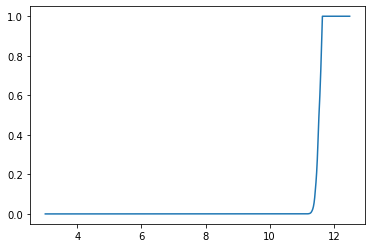

In [4]:
cdfs, CI_mhalo = compute_conf_intervals(phi_max_conv, log10m[:, :-1])
plt.plot(log10m[0, :-1], cdfs[0])


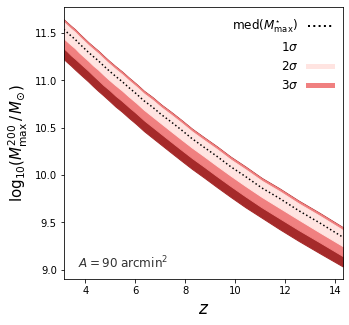

In [5]:
# CI_mhalo = compute_conf_ints(phi_max_conv, log10m[0, :-1])

colors = ['brown','lightcoral','mistyrose']

fig, ax = plt.subplots(1, 1, figsize=(5,5))

ax.fill_between(z, CI_mhalo[:,0], CI_mhalo[:,6], alpha=1, color=colors[0])
ax.fill_between(z, CI_mhalo[:,1], CI_mhalo[:,5], alpha=1, color=colors[1])
ax.fill_between(z, CI_mhalo[:,2], CI_mhalo[:,4], alpha=1, color=colors[2])
ax.plot(z, CI_mhalo[:,3], linestyle='dotted', c='black')

ax.set_xlim(np.min(z), np.max(z));
ax.set_xlabel('$z$', size=17)
ax.set_ylabel('$\mathrm{log_{10}}(M^{200}_{\mathrm{max}} \,/\, M_{\odot})$', size=15)
ax.text(0.05, 0.04, '$A = 90 \; \mathrm{arcmin}^2$', size=12, color='black', alpha=0.8, transform = ax.transAxes)

line1 = plt.Line2D((0,1),(0,0), color=colors[0], linewidth=5)
line2 = plt.Line2D((0,1),(0,0), color=colors[1], linewidth=5)
line3 = plt.Line2D((0,1),(0,0), color=colors[2], linewidth=5)
line4 = plt.Line2D((0,1),(0,0), color='black', linestyle='dotted', linewidth=2)
line_dummy = plt.Line2D((0,1),(0,0), color='white')
leg = ax.legend(handles=[line4,line_dummy,line3,line2,line1], 
           labels=['$\mathrm{med}(M^{\star}_{\mathrm{max}})$',
               '$1\sigma$', '$2\sigma$', '$3\sigma$'],
                frameon=False, loc='upper right', fontsize=12, ncol=1)

vp = leg._legend_box._children[-1]._children[0] 
for c in vp._children: c._children.reverse() 
vp.align="right" 

This shows the **maximum allowable** mass, given that the overdensity volume is modelled correctly, **and** that the overdensity is the most overdense of its kind in the survey volumne. Since we often do not know the exact volume of the overdensity, or that it is exactly the most overdense of its kind. We can therefore convolve the $M_{max}(\delta)$ distribution with a different distribution of overdensity extremity.

In [33]:
from scipy.stats import uniform, norm

def sigma_delta_gauss(sig_OD, n_samp):
    N = 1/(1-norm.cdf(sig_OD))
    x = np.linspace(1e-8, 1-1e-8, n_samp)
    evs = N*uniform.pdf(x)*pow(uniform.cdf(x), N - 1.)
    return evs, x

def sigma_delta_uniform(percentile, n_samp):
    N = 1/(1-percentile)
    x = np.linspace(1e-8, 1-1e-8, n_samp)
    evs = N*uniform.pdf(x)*pow(uniform.cdf(x), N - 1.)
    return evs, x

sig_OD = 4
evs, x = sigma_delta_gauss(sig_OD, n_samp = len(phi_maxs[0].T))
pdf_norms = []
for i in range(len(z)):
    mask = ~np.any(np.isnan(phi_maxs[i]), axis = 0)
    evs_m = evs[mask]
    pdf_norm = np.sum(phi_maxs[i][:,mask]*evs_m, axis = 1)/np.sum(evs_m)
    pdf_norms.append(pdf_norm)

(31, 1900)


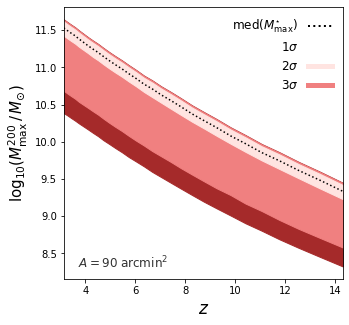

In [35]:
cdfs, CI_mhalo = compute_conf_intervals(pdf_norms, log10m[:, :-1])
colors = ['brown','lightcoral','mistyrose']

fig, ax = plt.subplots(1, 1, figsize=(5,5))

ax.fill_between(z, CI_mhalo[:,0], CI_mhalo[:,6], alpha=1, color=colors[0])
ax.fill_between(z, CI_mhalo[:,1], CI_mhalo[:,5], alpha=1, color=colors[1])
ax.fill_between(z, CI_mhalo[:,2], CI_mhalo[:,4], alpha=1, color=colors[2])
ax.plot(z, CI_mhalo[:,3], linestyle='dotted', c='black')

ax.set_xlim(np.min(z), np.max(z));
ax.set_xlabel('$z$', size=17)
ax.set_ylabel('$\mathrm{log_{10}}(M^{200}_{\mathrm{max}} \,/\, M_{\odot})$', size=15)
ax.text(0.05, 0.04, '$A = 90 \; \mathrm{arcmin}^2$', size=12, color='black', alpha=0.8, transform = ax.transAxes)

line1 = plt.Line2D((0,1),(0,0), color=colors[0], linewidth=5)
line2 = plt.Line2D((0,1),(0,0), color=colors[1], linewidth=5)
line3 = plt.Line2D((0,1),(0,0), color=colors[2], linewidth=5)
line4 = plt.Line2D((0,1),(0,0), color='black', linestyle='dotted', linewidth=2)
line_dummy = plt.Line2D((0,1),(0,0), color='white')
leg = ax.legend(handles=[line4,line_dummy,line3,line2,line1], 
           labels=['$\mathrm{med}(M^{\star}_{\mathrm{max}})$',
               '$1\sigma$', '$2\sigma$', '$3\sigma$'],
                frameon=False, loc='upper right', fontsize=12, ncol=1)

vp = leg._legend_box._children[-1]._children[0] 
for c in vp._children: c._children.reverse() 
vp.align="right" 


We can then again compute the confidence intervals, and plot. We also plot the $3\sigma$ upper limits from assuming a stellar fraction of unity (black dashed line), as a conservative upper limit.

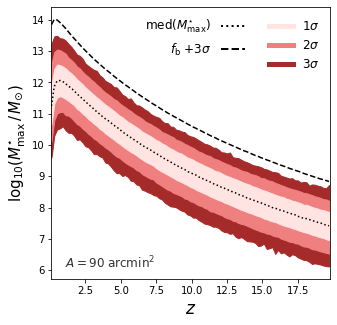

In [19]:
CIs = compute_conf_ints(mstar_pdf, log10m)

fig, ax = plt.subplots(1, 1, figsize=(5,5))

colors = ['brown','lightcoral','mistyrose']

ax.fill_between(z, CIs[:,0], CIs[:,6], alpha=1, color=colors[0])
ax.fill_between(z, CIs[:,1], CIs[:,5], alpha=1, color=colors[1])
ax.fill_between(z, CIs[:,2], CIs[:,4], alpha=1, color=colors[2])
ax.plot(z, CIs[:,3], linestyle='dotted', c='black')
ax.plot(z, CI_baryon[:,6], linestyle='dashed', color='black')

ax.set_xlim(0.1, 19.8); 
# ax.set_ylim(5.4, 11.8)
ax.set_xlabel('$z$', size=17)
ax.set_ylabel('$\mathrm{log_{10}}(M^{\star}_{\mathrm{max}} \,/\, M_{\odot})$', size=15)
ax.text(0.05, 0.04, '$A = 90 \; \mathrm{arcmin}^2$', size=12, color='black', alpha=0.8, transform = ax.transAxes)

line1 = plt.Line2D((0,1),(0,0), color=colors[0], linewidth=5)
line2 = plt.Line2D((0,1),(0,0), color=colors[1], linewidth=5)
line3 = plt.Line2D((0,1),(0,0), color=colors[2], linewidth=5)
line4 = plt.Line2D((0,1),(0,0), color='black', linestyle='dotted', linewidth=2)
line5 = plt.Line2D((0,1),(0,0), color='black', linestyle='dashed', linewidth=2)
line_dummy = plt.Line2D((0,1),(0,0), color='white')
leg = ax.legend(handles=[line4,line5,line_dummy,line3,line2,line1], 
           labels=['$\mathrm{med}(M^{\star}_{\mathrm{max}})$','$f_{\mathrm{b}}$ $+3\sigma$','',
               '$1\sigma$', '$2\sigma$', '$3\sigma$'],
                frameon=False, loc='upper right', fontsize=12, ncol=2)

vp = leg._legend_box._children[-1]._children[0] 
for c in vp._children: c._children.reverse() 
vp.align="right" 

### Using pre-calculated arrays of $f(m)$, $F(m)$ and $N$

In the example above we used pre-computed arrays for $f(m)$ and $F(m)$, with the sky fraction factored out. This allows arbitrary surveys areas to be calculated easily.

If you wish to explore the impact of changing the cosmology, or the chosen halo mass function parametrisation, these grids will need to be calculated again. A script for doing this is provided in `run_lightcone.py`. This can be called with an output filename as the first argument, and the necessary arrays will be saved to a HDF5 file. This can then be used as above. 